# Multiple Regression

### The Problem statement:

The dataset for this project is  from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. 

In this project, Multiple Regression will be implemented alongwith Regularization Technique. Model with the lowest RMSE over the test data will be selected .

The model is further deployed on AWS elastic Beanstalk and the corresponding Web Application is developed using FLASK framework.


In [310]:
# necessary Imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
sns.set()

### Load the dataset

In [336]:

boston = load_boston()
X = pd.DataFrame(boston.data,columns=boston.feature_names)
Y= pd.DataFrame(boston.target,columns=['Price'])
data=pd.concat([X,Y],axis=1)

In [308]:
# printing the summary of the dataframe
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [309]:
data.isna().sum() # finding the count of missing values from different columns

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
Price      0
dtype: int64

### Check the correlation between predictors and features

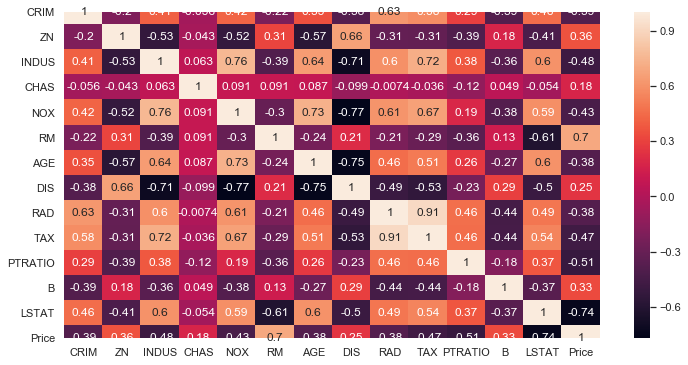

In [156]:

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.heatmap(data.corr(),annot=True)

In [ ]:
#Price is positively correlated with RM ,PTRATIO and negatively correlated with LSTAT
#NOX and DIS are highly correlated.
#RAD and TAX are highly correlated .It can be seen that many independent features are correlated to each other.
#B,RAD,DIS,AGE,CHAS have very low correlation coefficient.

### Data Visualization :1> Distribution of each feature 2> Scatter plot between Price and other features

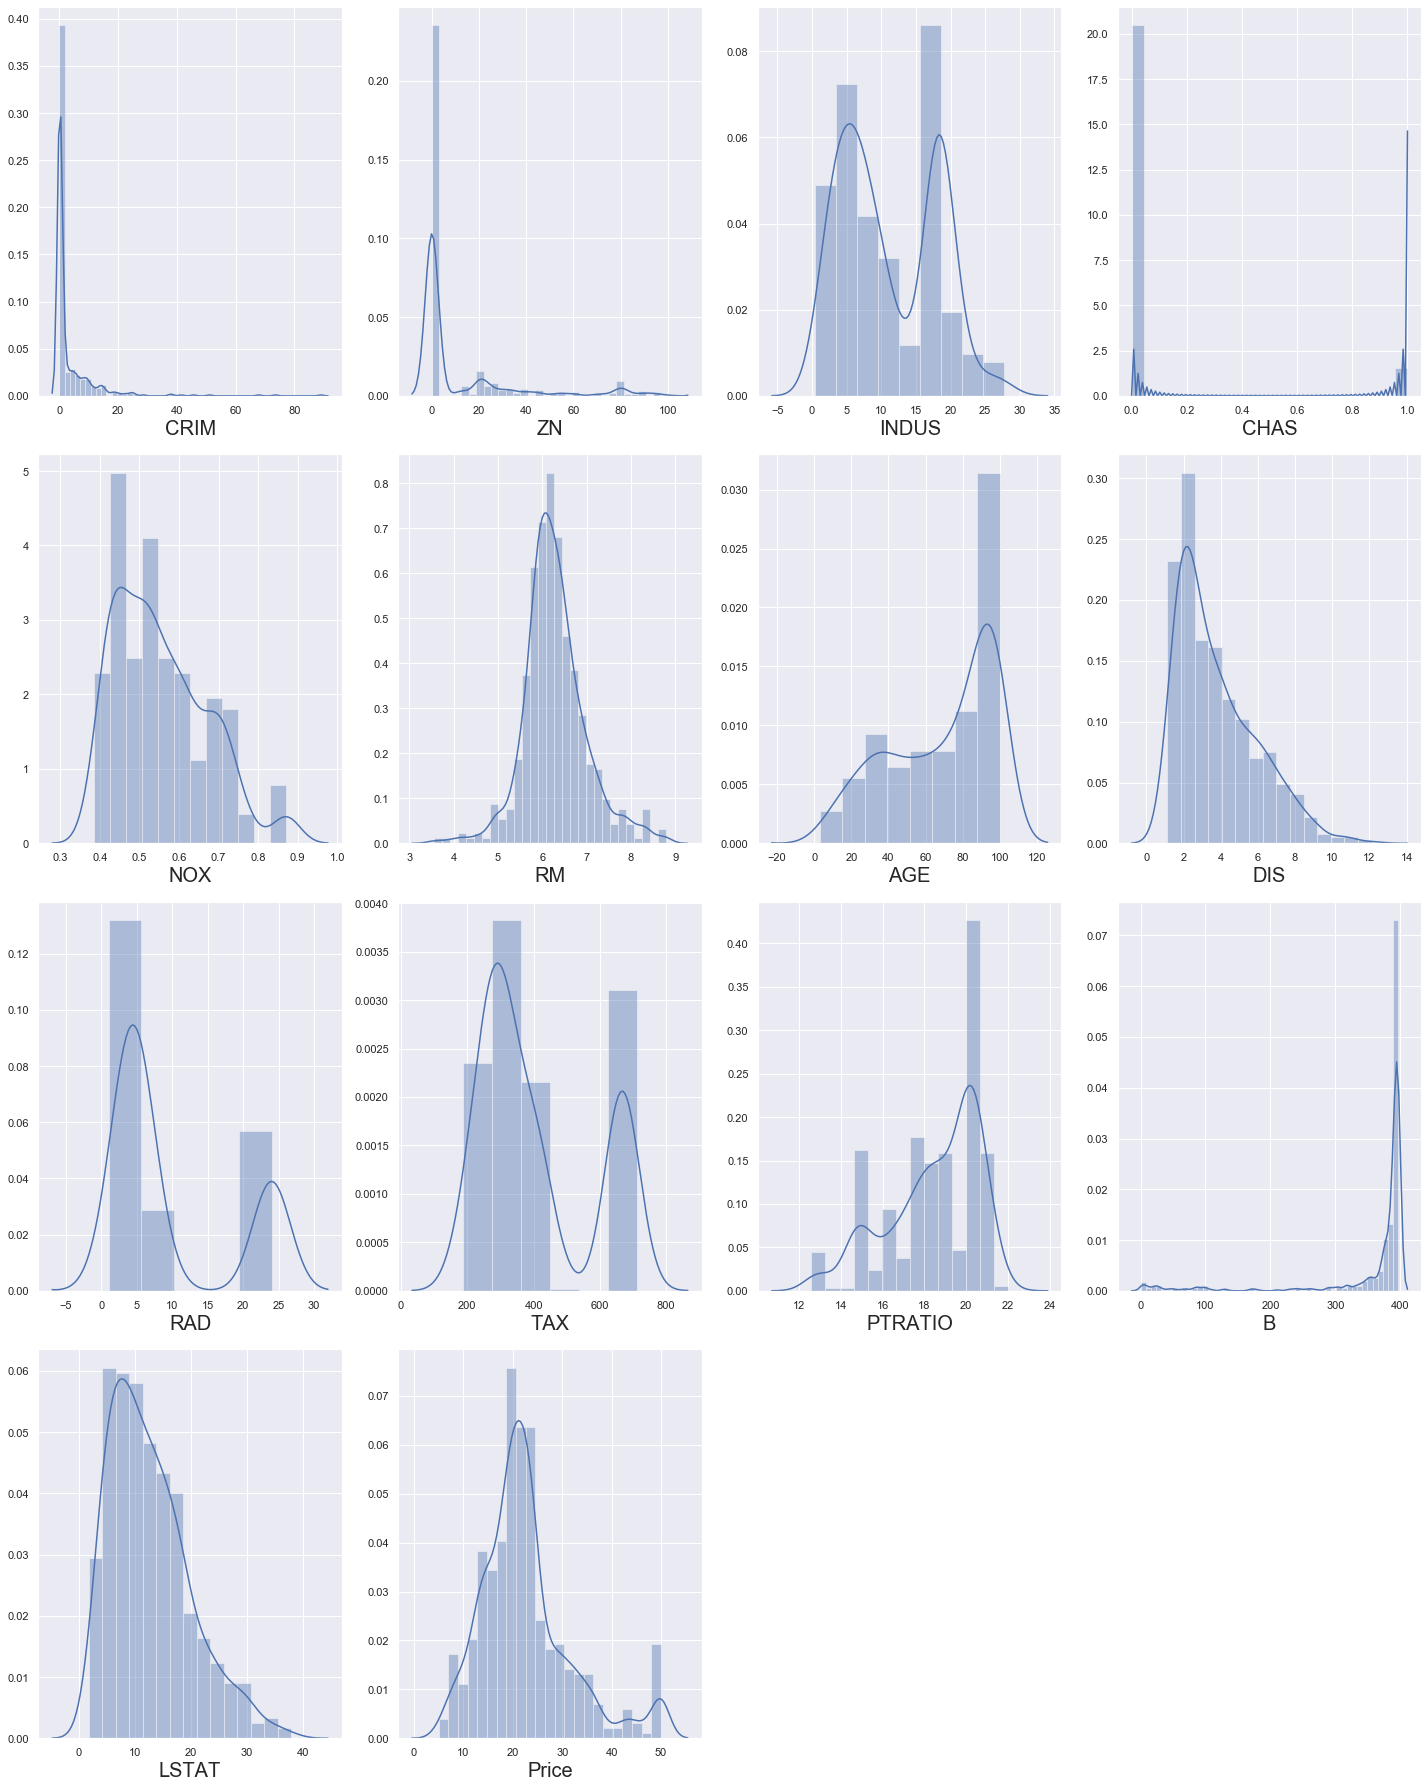

In [311]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data:
    if plotnumber<=14 :
        ax = plt.subplot(4,4,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

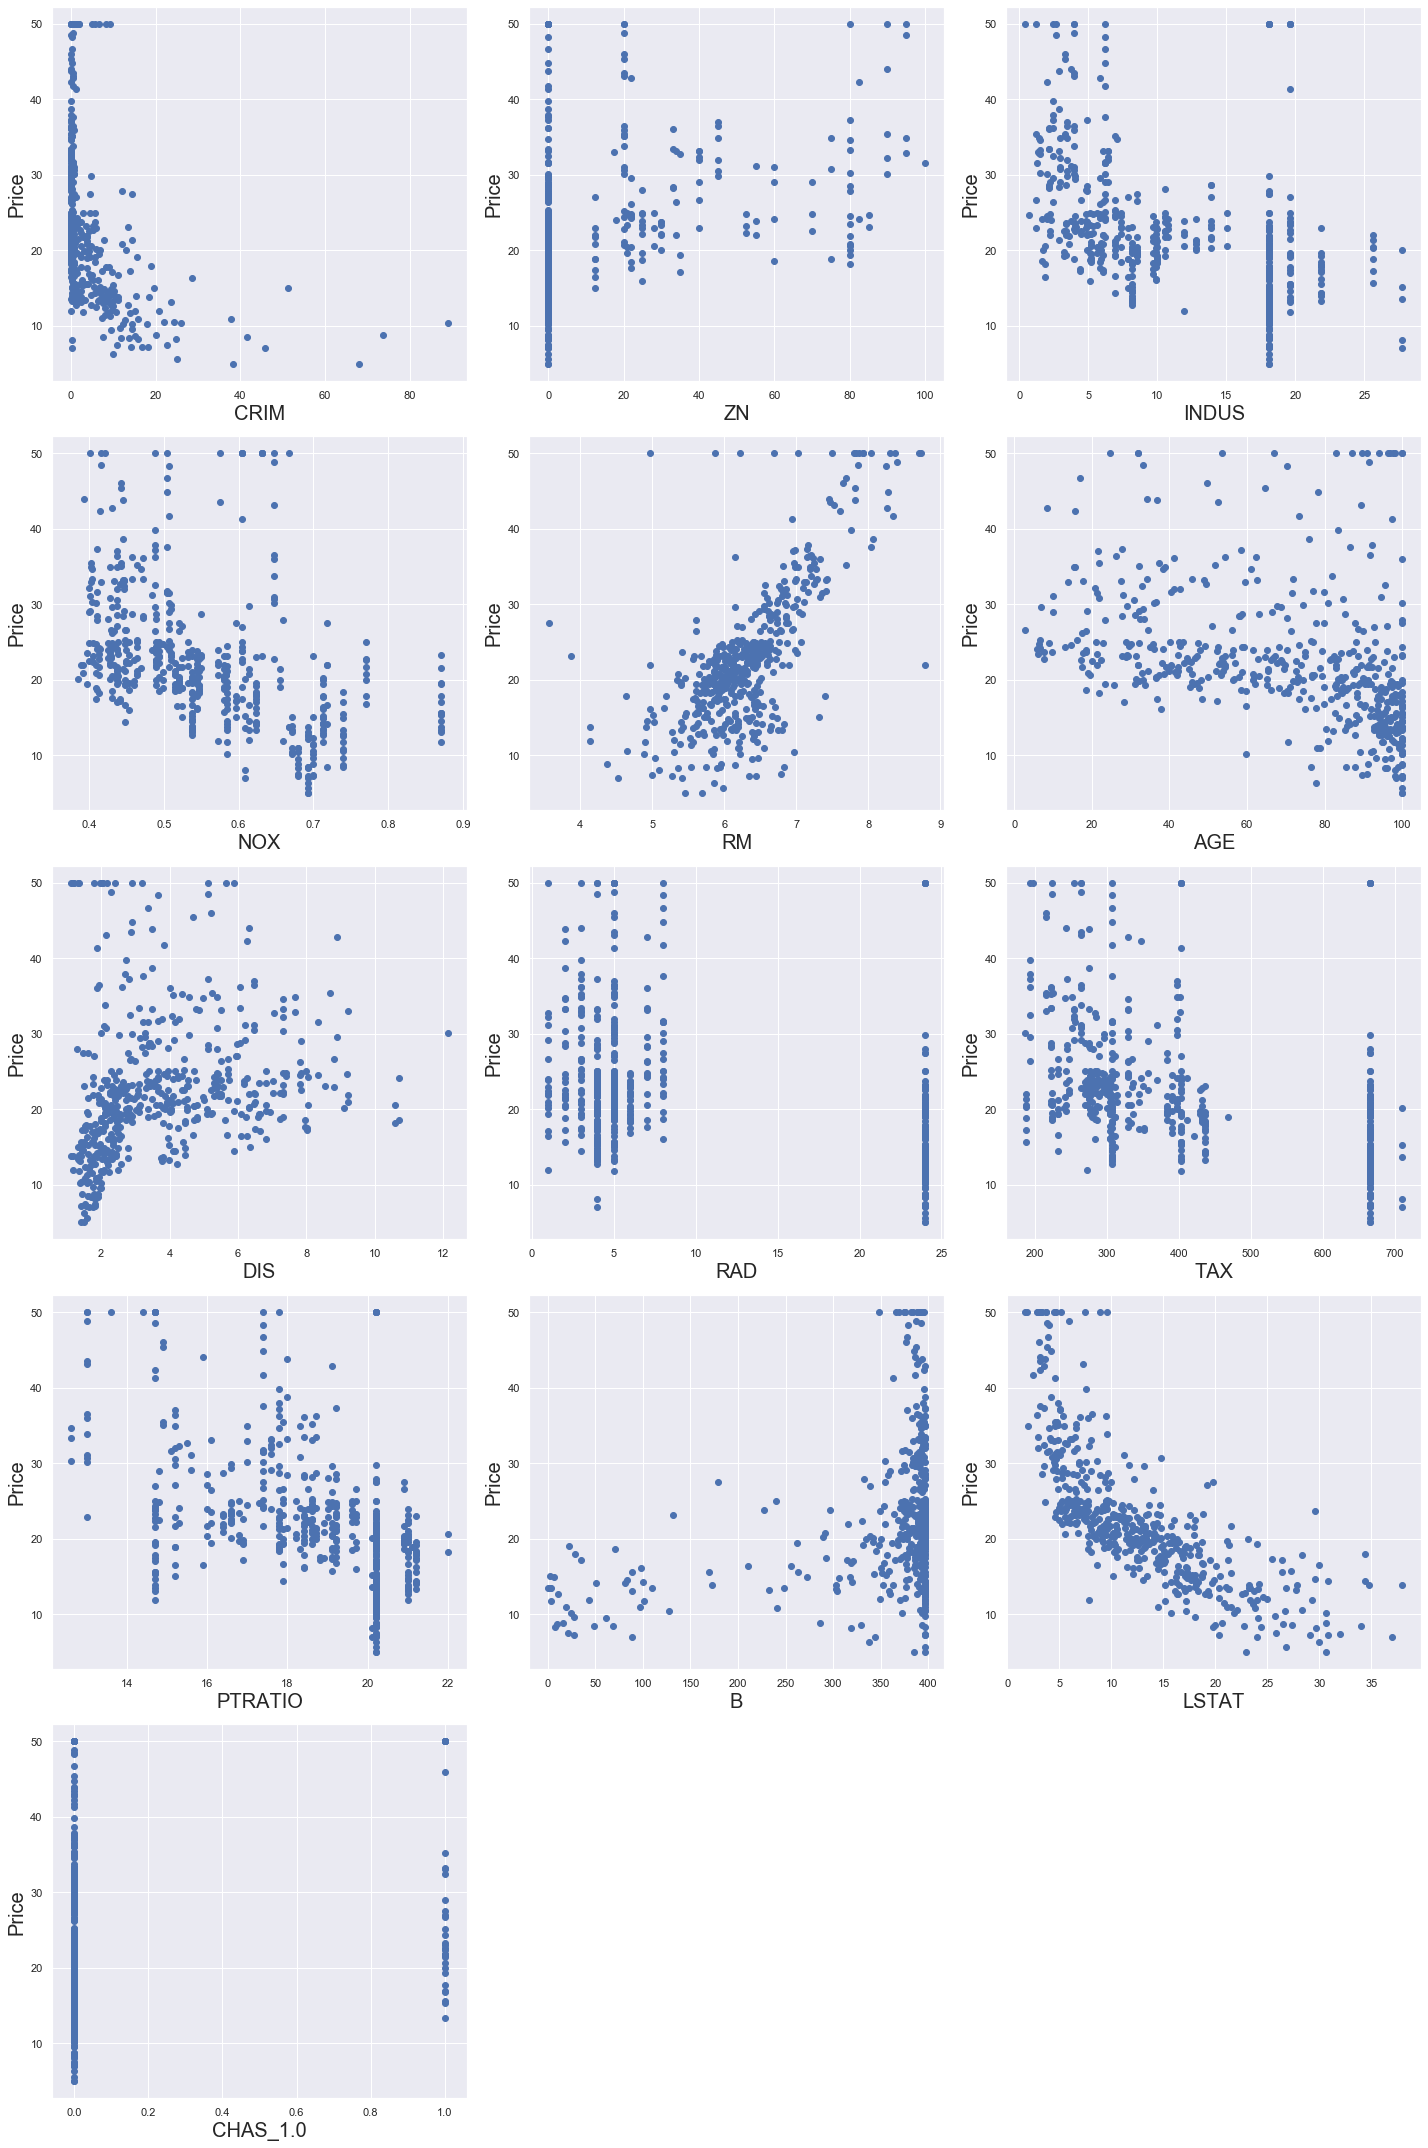

In [102]:
plt.figure(figsize=(20,30), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=14 :
        ax = plt.subplot(5,3,plotnumber)
        plt.scatter(X[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Price',fontsize=20)
    plotnumber+=1
plt.tight_layout()

In [312]:
#Create dummy columns for 'CHAS' input feature
data['CHAS']=data['CHAS'].astype('object')

for col in ['CHAS']:
    data=pd.get_dummies(data, columns=[col], prefix=[col], drop_first=True)

In [313]:
y = data['Price']
X =data.drop(columns = ['Price'])

In [314]:
#Scaling the numerical columns
numericalCols=[i for i in X.columns if X[i].dtypes=='float64']
numericalCols
scaler =StandardScaler()
X_scaled = scaler.fit_transform(X[numericalCols])

In [315]:
#Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables=X_scaled
#variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()
# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X[numericalCols].columns
vif
# INDUS,NOX,DIS,RAD,TAX features can be removed as it shows multicollinearity

,VIF,Features
0,1.787705,CRIM
1,2.298257,ZN
2,3.949246,INDUS
3,4.388775,NOX
4,1.931865,RM
5,3.092832,AGE
6,3.954961,DIS
7,7.397844,RAD
8,8.876233,TAX
9,1.783302,PTRATIO


#### Removing features whose VIF is more than 4;passing the corresponding indices in below function

In [316]:
X_scaled=np.delete(X_scaled, [3,7,8], 1)

In [317]:
#Shape after deletion of above columns
X_scaled.shape

(506, 9)

In [318]:
#add CHAS column in above numpyArray
X_scaled = np.column_stack((X_scaled, X['CHAS_1.0'].values))
print("Shape after adding categorical value")
X_scaled.shape

Shape after adding categorical value


(506, 10)

### Split the dataset 

In [319]:
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.20,random_state=40)

### Fit the Regression Model

In [320]:
regression = LinearRegression()
regression.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [321]:
modelList=[]
metrics={}
metrics['modelName']='Basic Linear Reg'
metrics['trainScore']=regression.score(x_train,y_train)
metrics['testScore']=regression.score(x_test,y_test)
pred=regression.predict(x_test) #predicting values of y for all the xtest rows
metrics['testRMSE']=mean_squared_error(y_test,pred)**0.5
modelList.append(metrics)
modelList


[{'modelName': 'Basic Linear Reg',
  'trainScore': 0.731150692362798,
  'testScore': 0.6790452740503389,
  'testRMSE': 6.033648879852117}]

So it looks like our model r2 score is less on the test data.

Let's see if our model is overfitting our training data.

### Fit lasso Regularization Model

In [323]:
# Lasso Regularization
# LassoCV will return best alpha and coefficients after performing 10 cross validations
lasscv = LassoCV(alphas = None,cv =10, max_iter = 10000, normalize = True)
lasscv.fit(x_train, y_train)
lasscv

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [327]:
# best alpha parameter
alpha = lasscv.alpha_
print("alpha value is",alpha)
lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train, y_train)

alpha value is 0.00032337021059991285


Lasso(alpha=0.00032337021059991285, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [328]:
metrics={}
metrics['modelName']='Lasso Reg'
metrics['trainScore']=lasso_reg.score(x_train,y_train)
metrics['testScore']=lasso_reg.score(x_test,y_test)
pred=lasso_reg.predict(x_test) #predicting values of y for all the xtest rows
metrics['testRMSE']=mean_squared_error(y_test,pred)**0.5
modelList.append(metrics)
modelList

[{'modelName': 'Basic Linear Reg',
  'trainScore': 0.731150692362798,
  'testScore': 0.6790452740503389,
  'testRMSE': 6.033648879852117},
 {'modelName': 'Lasso Reg',
  'trainScore': 0.7311506504311972,
  'testScore': 0.6790405587096464,
  'testRMSE': 6.0336932016883305}]

In [329]:
#The metrics from both the regression Model is almost same. So going with the first Model

### Plot Actual data vs Predicted data

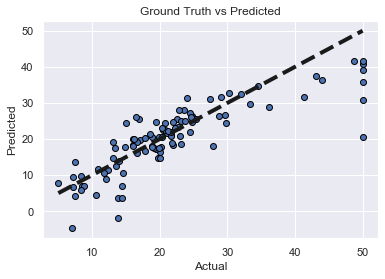

In [330]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [332]:
#Saving the model
# saving the model to the local file system
filename1 = 'regression_model.pickle'
pickle.dump(regression, open(filename1, 'wb'))
fileName2= 'scaler_transformation.pickle'
pickle.dump(scaler, open(fileName2, 'wb'))
# prediction using the saved model


#### Predict new data sample

In [333]:
#transform all the numerical columns
temp_scaled=scaler.transform([[0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98]])
#Delete columns which are not used in prediction. Provided the corresponding indices
temp_scaled=np.delete(temp_scaled, [3,7,8], 1)
#Added the CHAS value as 0 as shown below:
temp_scaled = np.column_stack((temp_scaled,0))
temp_scaled


array([[-0.41978194,  0.28482986, -1.2879095 ,  0.41367189, -0.12001342,
         0.1402136 , -1.45900038,  0.44105193, -1.0755623 ,  0.        ]])

In [ ]:
round(predicted_price)

In [338]:
#Now predict the outcome of above dataset
loaded_model = pickle.load(open(filename, 'rb'))
predicted_price=loaded_model.predict(temp_scaled)
print("Predicted House price is",predicted_price[0])

Predicted House price is 31.463972715960566


In [339]:
round(predicted_price[0],2)

31.46

### Cloud Deployment (AWS Elastic Beanstalk)

Once the training is completed, we need to expose the trained model as an API for the user to consume it. For prediction, the saved model is loaded first and then the predictions are made using it. If the web app works fine, the same app is deployed to the cloud platform. The application flow for cloud deployment looks like:

<img src="envCreation.PNG" width= "1000">

###### Flask App

As we’ll expose the created model as a web Application  to be consumed by the client, we’d do it using the flask framework. 


Create the project structure, as shown below:
<img src="flask.PNG" width= "1000">

#### Deployment to AWS Elastic Beanstalk

Web UI  where user can input the feature values

<img src="model UI.PNG" width= "1000">

Prediction of above inputs:

<img src="prediction.PNG" width= "1000">